# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 46kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

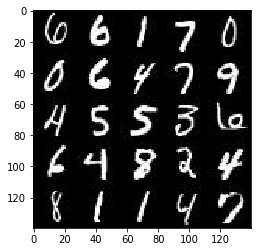

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

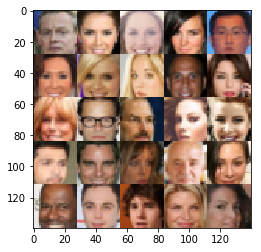

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape = [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1

    with tf.variable_scope('discriminator', reuse=reuse):
    
        l_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        l_1 = tf.maximum(alpha*l_1, l_1)
        
        l_2 = tf.layers.conv2d(l_1, 128, 5, strides=2, padding='SAME')
        l_2 = tf.layers.batch_normalization(l_2, training=True)
        l_2 = tf.maximum(alpha*l_2, l_2)
        
        l_3 = tf.layers.conv2d(l_2, 256, 5, strides=2, padding='SAME')
        l_3 = tf.layers.batch_normalization(l_3, training=True)
        l_3 = tf.maximum(alpha*l_3, l_3)
        
        flat = tf.reshape(l_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        l_1 = tf.layers.dense(z, 7*7*256)
        l_1 = tf.reshape(l_1, (-1, 7, 7, 256))
        l_1 = tf.layers.batch_normalization(l_1, training=is_train)
        l_1 = tf.maximum(alpha*l_1, l_1)
        
        l_2 = tf.layers.conv2d_transpose(l_1, 128, 5, strides=2, padding='SAME')
        l_2 = tf.layers.batch_normalization(l_2, training=is_train)
        l_2 = tf.maximum(alpha*l_2, l_2)
        
        l_3 = tf.layers.conv2d_transpose(l_2, 64, 5, strides=2, padding='SAME')
        l_3 = tf.layers.batch_normalization(l_3, training=is_train)
        l_3 = tf.maximum(alpha*l_3, l_3)
        
        logits = tf.layers.conv2d_transpose(l_3, out_channel_dim, 5, strides=1, padding='SAME')
        output = tf.tanh(logits)
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Generator
    g_model = generator(input_z, out_channel_dim)
    
    # Discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # D-loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    # G-loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_w, img_h, img_d = data_shape
    input_real, input_z, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_images *= 2 # should be normalized to generator images
                steps += 1

                # Sample input noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_d, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5498... Generator Loss: 1.9958
Epoch 1/2... Discriminator Loss: 1.6370... Generator Loss: 0.3979
Epoch 1/2... Discriminator Loss: 0.3952... Generator Loss: 1.7559
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.9282
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 1.1916
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 0.8746
Epoch 1/2... Discriminator Loss: 0.9898... Generator Loss: 1.7744
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 0.9166
Epoch 1/2... Discriminator Loss: 0.9427... Generator Loss: 1.1160


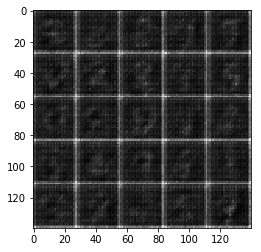

Epoch 1/2... Discriminator Loss: 0.9422... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 1.1727
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 0.9829... Generator Loss: 0.7727
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 0.7938... Generator Loss: 1.4760
Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 1.7471
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.1588


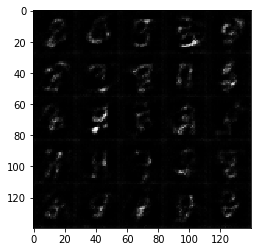

Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 0.6242
Epoch 1/2... Discriminator Loss: 0.6590... Generator Loss: 1.2213
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 1.3747
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 0.8169... Generator Loss: 0.8673
Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 0.9766
Epoch 1/2... Discriminator Loss: 0.6402... Generator Loss: 1.4005
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 1.1573
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.7263


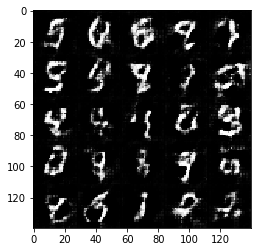

Epoch 1/2... Discriminator Loss: 0.8150... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 1.3797
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.1763
Epoch 1/2... Discriminator Loss: 1.4896... Generator Loss: 0.4039
Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 1.5577
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.5046... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 0.9368
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 0.6988


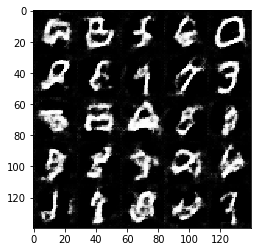

Epoch 1/2... Discriminator Loss: 0.8332... Generator Loss: 1.5030
Epoch 1/2... Discriminator Loss: 0.8526... Generator Loss: 1.2189
Epoch 1/2... Discriminator Loss: 0.8021... Generator Loss: 1.5161
Epoch 1/2... Discriminator Loss: 0.8587... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.3405
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 0.9045
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 0.7906... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 2.1558


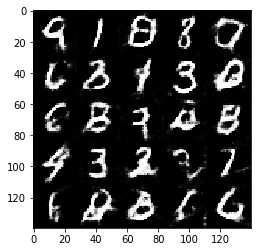

Epoch 1/2... Discriminator Loss: 0.7464... Generator Loss: 1.0593
Epoch 1/2... Discriminator Loss: 0.8377... Generator Loss: 1.5394
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.6383
Epoch 1/2... Discriminator Loss: 0.7816... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 0.9630... Generator Loss: 1.7234
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 0.5401
Epoch 1/2... Discriminator Loss: 0.8077... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 0.8144
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 2.2120


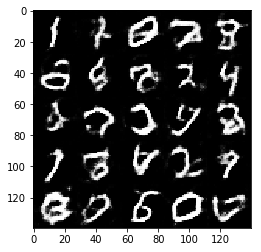

Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.5014
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 0.7912
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 0.7336... Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 0.8959... Generator Loss: 1.8649
Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 1.5836
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 0.5856
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 1.2340


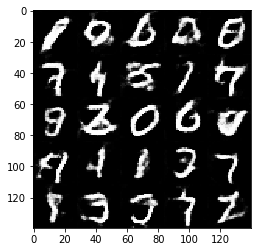

Epoch 1/2... Discriminator Loss: 0.8659... Generator Loss: 0.9759
Epoch 1/2... Discriminator Loss: 0.7716... Generator Loss: 1.0181
Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 1.4756
Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 1.2531
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 1.0565
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 1.4395
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 0.9232
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 1.2647
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.4241


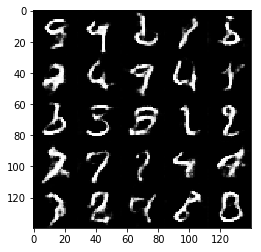

Epoch 1/2... Discriminator Loss: 0.8724... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 1.8513
Epoch 1/2... Discriminator Loss: 0.8193... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 0.6296... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 1.7352
Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 0.7491... Generator Loss: 1.0718
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 0.8492


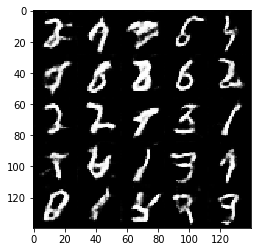

Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 0.7871... Generator Loss: 1.0933
Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 0.3354
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 2.2464
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 0.8106
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 0.9503
Epoch 2/2... Discriminator Loss: 1.0474... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.1242
Epoch 2/2... Discriminator Loss: 1.3024... Generator Loss: 0.4770


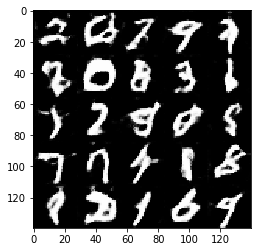

Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 0.9971
Epoch 2/2... Discriminator Loss: 0.9907... Generator Loss: 0.6365
Epoch 2/2... Discriminator Loss: 0.8149... Generator Loss: 0.9690
Epoch 2/2... Discriminator Loss: 0.9576... Generator Loss: 2.0543
Epoch 2/2... Discriminator Loss: 1.2342... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 0.9408... Generator Loss: 1.2282
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 0.5810... Generator Loss: 1.1830
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 0.5465
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.4635


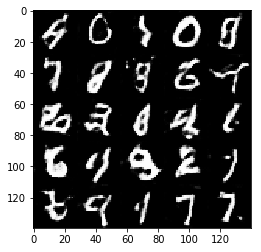

Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 0.6882... Generator Loss: 2.1532
Epoch 2/2... Discriminator Loss: 0.6830... Generator Loss: 1.1888
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 1.6591
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.1112
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 0.8239... Generator Loss: 1.0735
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 0.7470
Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 0.9729


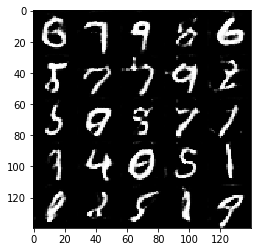

Epoch 2/2... Discriminator Loss: 0.7985... Generator Loss: 1.0089
Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.2825
Epoch 2/2... Discriminator Loss: 0.6248... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.4713
Epoch 2/2... Discriminator Loss: 0.7013... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.4033
Epoch 2/2... Discriminator Loss: 0.7391... Generator Loss: 1.0791
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.3888


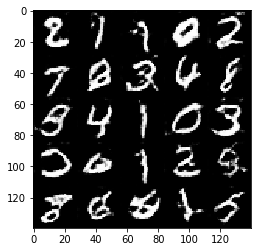

Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.4865
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 1.6869... Generator Loss: 0.3754
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.0930
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.3946
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 1.5441
Epoch 2/2... Discriminator Loss: 0.6099... Generator Loss: 1.4118


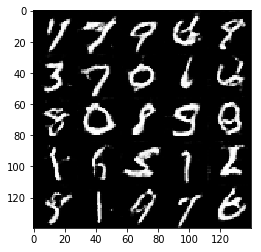

Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.2653
Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 0.8642... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 1.7578
Epoch 2/2... Discriminator Loss: 0.5975... Generator Loss: 1.5569
Epoch 2/2... Discriminator Loss: 2.0429... Generator Loss: 0.2148
Epoch 2/2... Discriminator Loss: 0.5713... Generator Loss: 1.4769
Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 0.7695


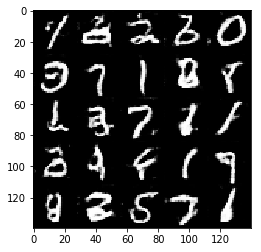

Epoch 2/2... Discriminator Loss: 0.7480... Generator Loss: 0.9680
Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 1.7419
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 1.2627
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 1.1222
Epoch 2/2... Discriminator Loss: 0.7836... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.4090
Epoch 2/2... Discriminator Loss: 0.6533... Generator Loss: 1.3017
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 0.4938


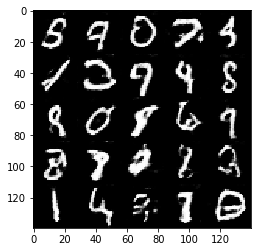

Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.1721
Epoch 2/2... Discriminator Loss: 0.9451... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 1.2674
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 0.7852... Generator Loss: 1.0991
Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.2469
Epoch 2/2... Discriminator Loss: 0.7526... Generator Loss: 1.7009
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 1.5719
Epoch 2/2... Discriminator Loss: 0.6339... Generator Loss: 1.6919


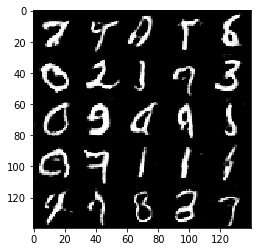

Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.3310
Epoch 2/2... Discriminator Loss: 0.8106... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 1.0181
Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 1.7711
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.3890
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 1.1072
Epoch 2/2... Discriminator Loss: 0.5398... Generator Loss: 1.2849
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 0.7240


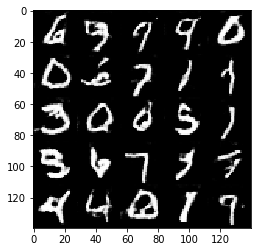

Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 1.6812
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 0.5561... Generator Loss: 1.5964
Epoch 2/2... Discriminator Loss: 0.4829... Generator Loss: 1.5388
Epoch 2/2... Discriminator Loss: 0.8034... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 1.5245
Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 1.5300


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 1.8510
Epoch 1/1... Discriminator Loss: 0.1836... Generator Loss: 2.3221
Epoch 1/1... Discriminator Loss: 0.2200... Generator Loss: 2.2755
Epoch 1/1... Discriminator Loss: 0.2165... Generator Loss: 2.2314
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 6.3806
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 1.5445
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 2.1832
Epoch 1/1... Discriminator Loss: 0.3668... Generator Loss: 1.9122


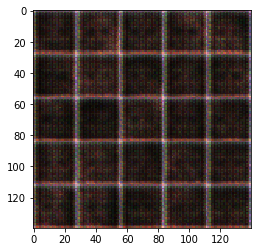

Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 1.7243
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 2.3815
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.4708... Generator Loss: 2.2437
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 1.5947
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 3.0544
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 2.4443
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 1.5690


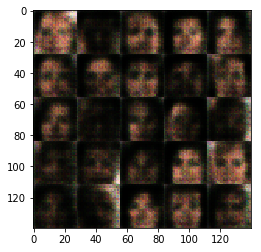

Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 2.2113
Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 1.4985
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 2.6460
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 1.4841
Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 1.7603
Epoch 1/1... Discriminator Loss: 0.3160... Generator Loss: 2.2074


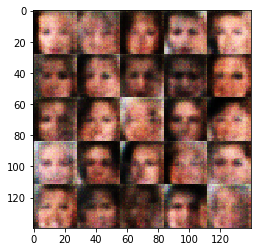

Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 1.9667
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 1.5303
Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 1.7517
Epoch 1/1... Discriminator Loss: 0.3869... Generator Loss: 1.9572
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 2.4781
Epoch 1/1... Discriminator Loss: 0.2103... Generator Loss: 2.4896
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 2.0841
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 2.2521
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 1.2595


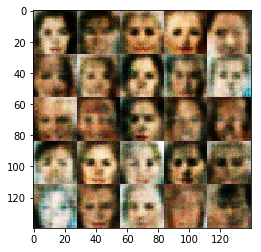

Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 2.3791
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 0.4845... Generator Loss: 2.9366
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 1.4975
Epoch 1/1... Discriminator Loss: 0.2794... Generator Loss: 2.8524
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 1.9027
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 1.6538
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.3072


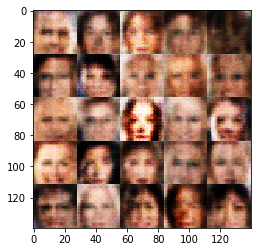

Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 2.2173
Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 1.4373
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 2.1847
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.5254
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 2.6139
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 1.8073
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 1.9010


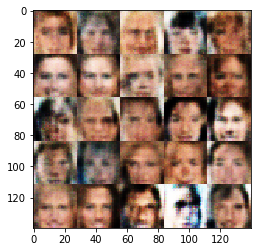

Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 2.3666
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 1.6505
Epoch 1/1... Discriminator Loss: 0.6669... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.4554... Generator Loss: 2.2978
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 1.3401
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 3.1406


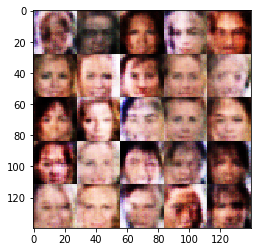

Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.6043
Epoch 1/1... Discriminator Loss: 0.5436... Generator Loss: 1.7053
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 2.3557
Epoch 1/1... Discriminator Loss: 1.9051... Generator Loss: 0.2088
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 2.8068


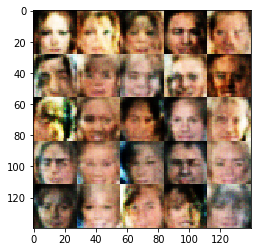

Epoch 1/1... Discriminator Loss: 0.3079... Generator Loss: 2.6713
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 2.9789
Epoch 1/1... Discriminator Loss: 0.3768... Generator Loss: 2.0889
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 0.3495... Generator Loss: 2.6743
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 1.4587
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 3.9618
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.4091
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 1.8823


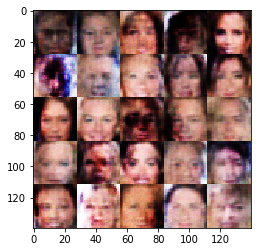

Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 2.2061
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 2.0954
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 1.7705
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 4.0921
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 0.8898


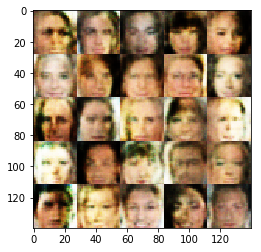

Epoch 1/1... Discriminator Loss: 0.4646... Generator Loss: 2.2067
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 3.0478
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.5556
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 3.3070
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 2.0393
Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 2.6532
Epoch 1/1... Discriminator Loss: 0.2869... Generator Loss: 1.9003


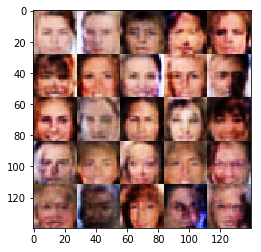

Epoch 1/1... Discriminator Loss: 0.6259... Generator Loss: 2.4659
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 2.3994
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 3.2297
Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 1.1685
Epoch 1/1... Discriminator Loss: 0.3131... Generator Loss: 2.4144
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 3.2655
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 2.1967
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 1.4927


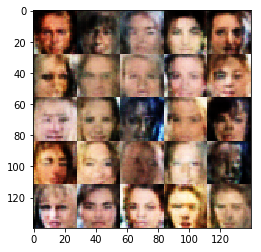

Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 1.2462
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 1.8441
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 2.3453
Epoch 1/1... Discriminator Loss: 0.3031... Generator Loss: 3.2897
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 2.3285
Epoch 1/1... Discriminator Loss: 0.1929... Generator Loss: 2.9082
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 3.0161


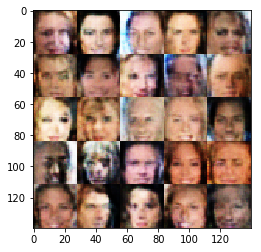

Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 4.0704
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 3.2284
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 3.8693
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 1.6388
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 2.1182
Epoch 1/1... Discriminator Loss: 0.3123... Generator Loss: 2.1053
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 1.2373


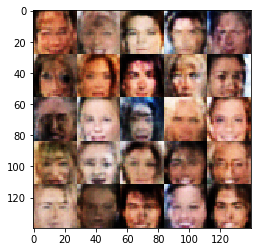

Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.7963
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 0.2658... Generator Loss: 2.2404
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 2.3396
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.8051


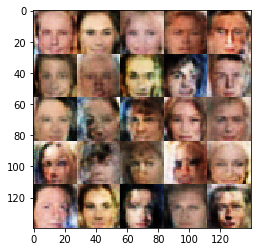

Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 2.3950
Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 2.0620
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.3934
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 1.8714
Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 2.6470
Epoch 1/1... Discriminator Loss: 0.3181... Generator Loss: 2.1532
Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 1.9608
Epoch 1/1... Discriminator Loss: 0.6960... Generator Loss: 2.4741


In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.